In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

## Data preparation

In [4]:
path = Path()
path_data = Path('data')

In [5]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [6]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
df = df[(df.Div.isin(div)) & (df.Season >= 18) & (df.Season <= 21)]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [7]:
add_datepart(df, 'Date');

In [8]:
procs = [Categorify, FillMissing, Normalize]

In [9]:
valid_idx = list(df.query('Season == 21').index)

In [10]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [11]:
splits

((#12557) [0,1,2,3,4,5,6,7,8,9...],
 (#1272) [918,919,920,921,922,923,924,925,926,927...])

In [12]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam', 'Dayofweek']
# cont_names = list(df.columns[df.columns.str.contains('For') | df.columns.str.contains('Against')]) + ['Year', 'Month', 'Week', 'Day', 'Dayofyear']
cont_names = list(df.columns[df.columns.str.contains('Avg')]) + ['Year', 'Month', 'Week', 'Day', 'Dayofyear']

In [13]:
y_block = RegressionBlock(n_out=2)

In [14]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
12137,SP1,Eibar,Villarreal,1.0,3.0,16.0,13.0,7.0,8.0,7.0,...,14,6,73,False,False,False,False,False,False,1.615680e+09
8639,F2,Rodez,Guingamp,1.0,1.0,8.0,17.0,3.0,6.0,4.0,...,28,5,333,False,False,False,False,False,False,1.606522e+09
8270,F2,Chambly,Grenoble,0.0,0.0,5.0,7.0,1.0,2.0,7.0,...,9,4,221,False,False,False,False,False,False,1.565309e+09
11208,SP1,Alaves,Villarreal,2.0,1.0,19.0,9.0,6.0,2.0,8.0,...,28,6,301,False,False,False,False,False,False,1.540685e+09
1987,D2,Hannover,Schalke 04,0.0,1.0,1.0,22.0,0.0,6.0,2.0,...,15,4,288,False,False,False,False,False,False,1.634256e+09
11641,SP1,Villarreal,Ath Madrid,0.0,0.0,23.0,18.0,3.0,3.0,11.0,...,6,4,340,False,False,False,False,False,False,1.575590e+09
9636,I1,Torino,Sampdoria,1.0,3.0,2.0,8.0,2.0,6.0,2.0,...,8,5,39,False,False,False,False,False,False,1.581120e+09
3611,E1,Preston,Norwich,3.0,1.0,11.0,22.0,4.0,10.0,3.0,...,13,2,44,False,False,False,False,False,False,1.550016e+09
13735,SP2,Tenerife,Ponferradina,2.0,0.0,17.0,12.0,4.0,4.0,5.0,...,4,5,247,False,False,False,False,False,False,1.630714e+09
11328,SP1,Eibar,Girona,3.0,0.0,17.0,6.0,5.0,2.0,8.0,...,3,6,34,False,False,False,False,False,False,1.549152e+09


In [15]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [16]:
to.cat_names, to.cont_names

((#4) ['Div','HomeTeam','AwayTeam','Dayofweek'],
 (#29) ['FTHGLast5Avg','HSLast5Avg','HSTLast5Avg','HCLast5Avg','FTAGLast5Avg','ASLast5Avg','ASTLast5Avg','ACLast5Avg','HomeFTGForLast5Avg','HomeSForLast5Avg'...])

In [17]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear
13827,11,188,176,7,0.563297,-0.709497,0.303032,0.189180,-0.302654,-0.959655,-1.171684,-0.706870,-0.491326,-0.119342,-0.446405,-0.942496,-1.188423,-0.407657,-1.238179,-0.113813,-0.204553,-0.763989,-0.347701,-0.257181,-0.510525,-0.852060,-0.933548,-0.64844,1.464103,0.870623,0.866043,0.909289,0.929144
13828,11,100,267,1,-0.992473,0.004695,-0.123153,0.875491,-0.302654,0.620303,-0.692427,0.050242,-0.824614,-0.194881,0.158600,0.824974,-1.188423,-0.258233,-1.238179,0.176294,0.143374,0.187601,-0.191385,-0.109818,-1.217299,-0.333873,-1.566135,-0.64844,1.464103,0.870623,0.924624,1.020814,0.937554


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [18]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [19]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [20]:
X_train.shape, y_train.shape

((12557, 33), (12557, 2))

In [21]:
X_test.shape, y_test.shape

((1272, 33), (1272, 2))

## LightGBM

In [25]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [26]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/home/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [27]:
import lightgbm as lgbm

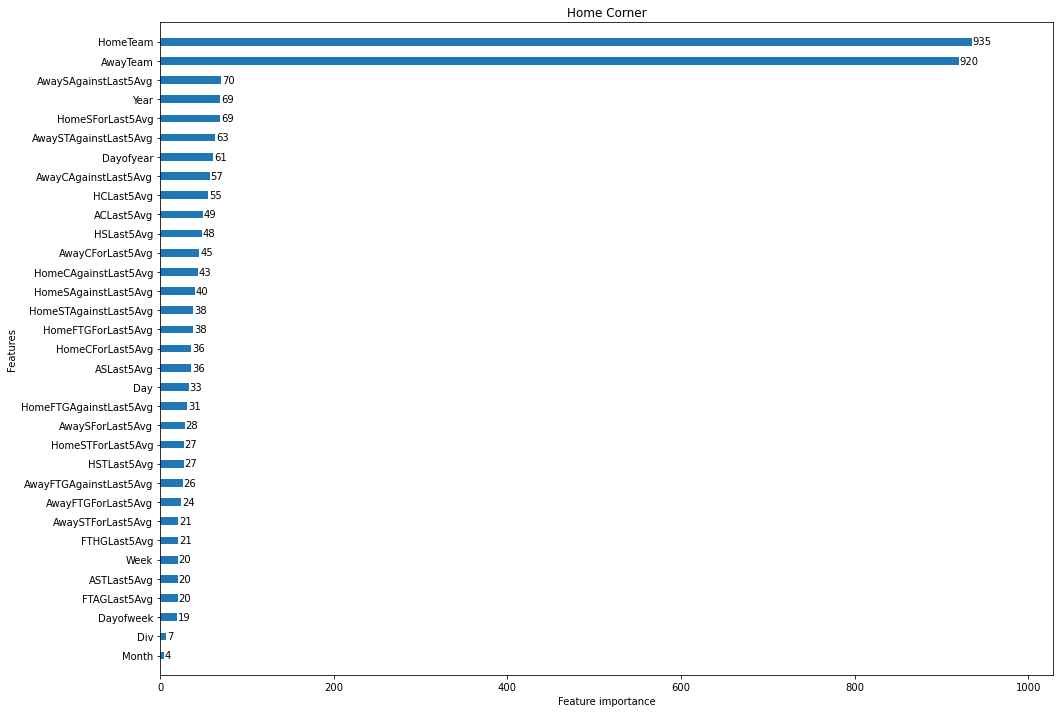

In [28]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

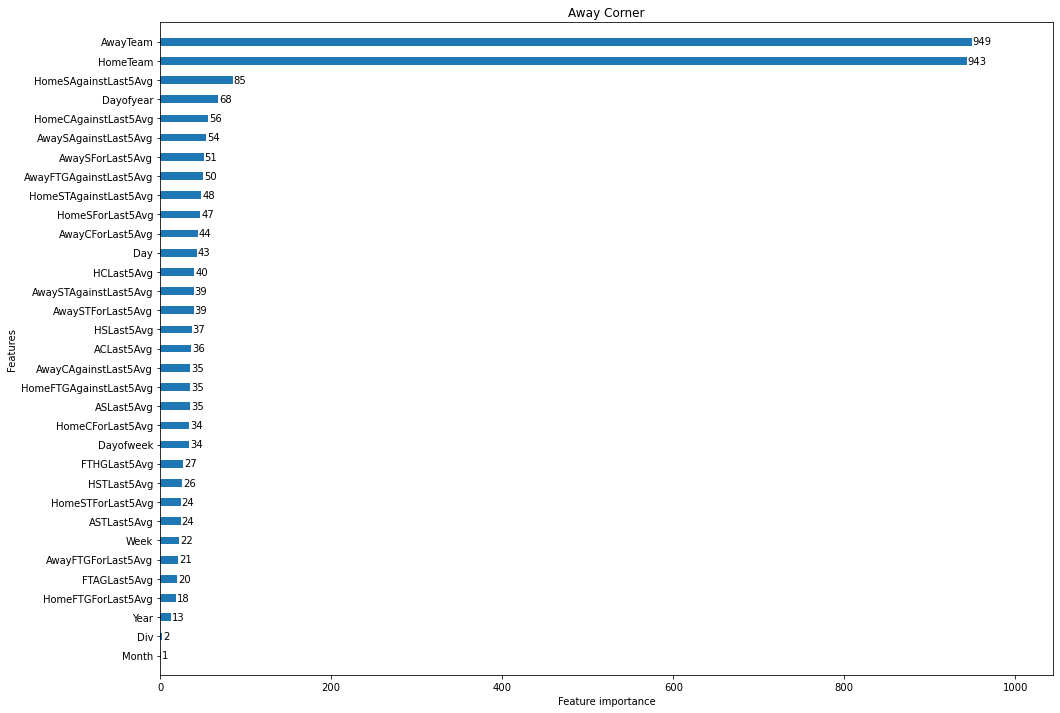

In [29]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [30]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='gpu_hist'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [31]:
import xgboost as xgb

In [32]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

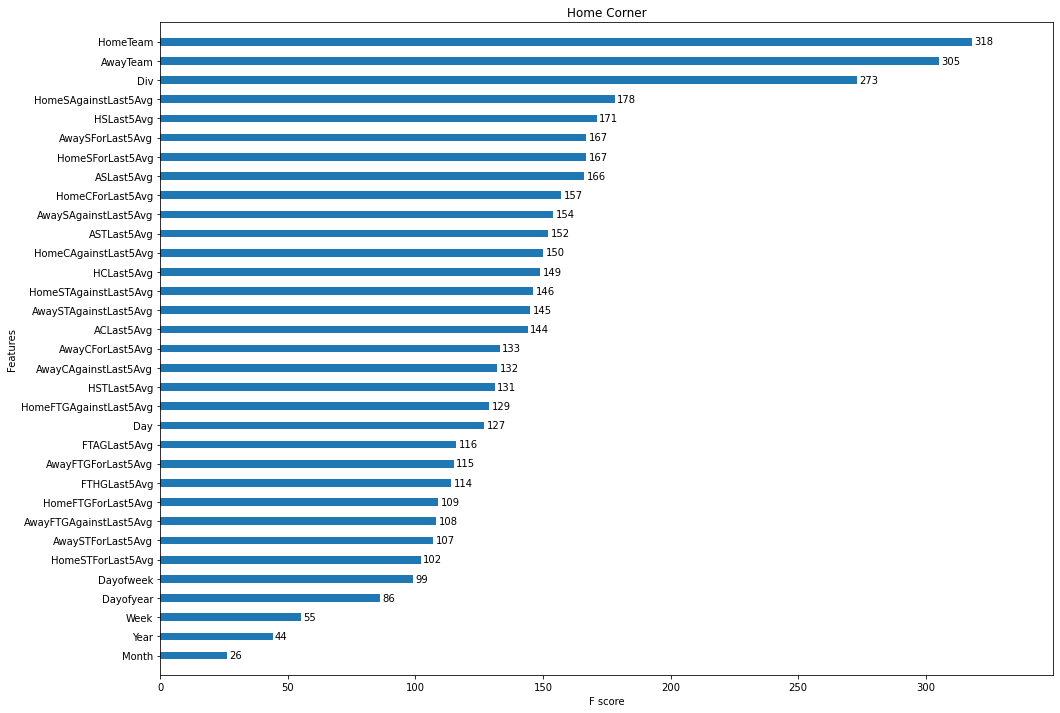

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

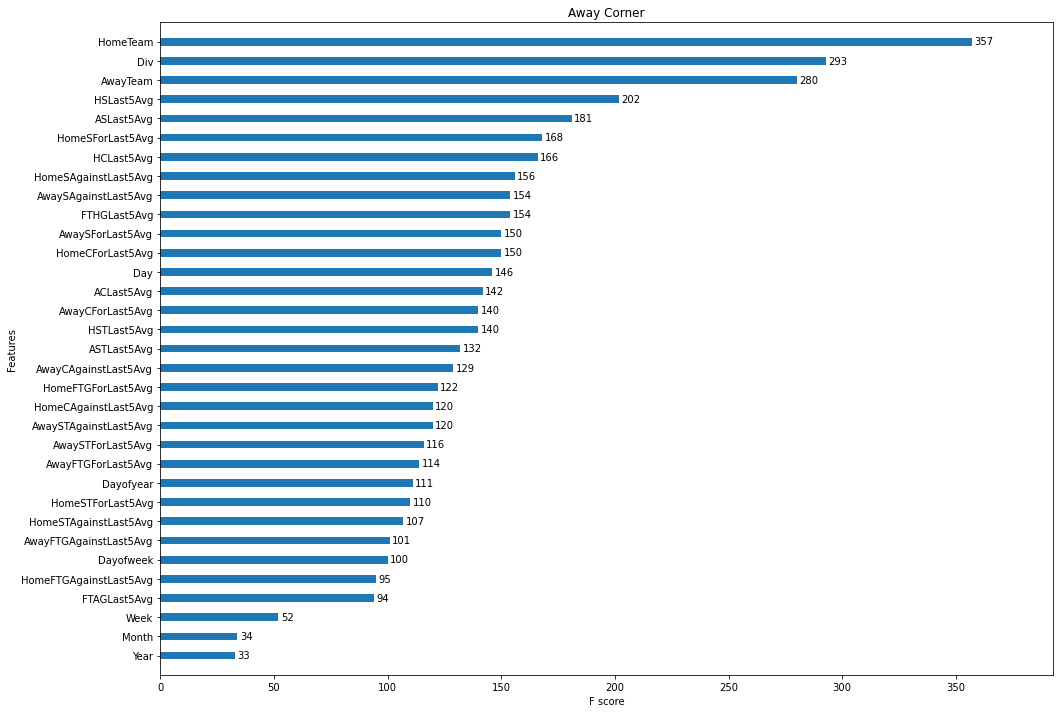

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [35]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC
0,D2,Paderborn,Bochum,5,1.8,14.000000,3.6,4.2,2.0,14.6,6.4,5.4,1.4,13.0,5.2,4.2,2.0,12.400000,5.6,6.2,1.6,14.600000,4.6,4.4,0.8,11.8,3.8,4.4,2021.0,4.0,14.0,10.0,99.999998,0.0,5.0
1,E1,Rotherham,Millwall,5,2.0,17.799999,5.6,8.8,1.6,11.6,3.6,7.0,1.2,14.6,3.8,7.4,1.8,11.800000,4.6,6.2,1.2,8.600000,3.6,3.4,1.0,12.8,4.8,4.6,2020.0,9.0,38.0,19.0,263.000000,8.0,3.0
2,SP1,Betis,Ath Madrid,6,1.6,7.800000,3.2,5.0,1.8,13.4,5.4,5.8,1.2,8.0,2.4,5.4,1.6,12.800000,6.2,4.6,1.6,11.800000,4.4,5.6,0.2,12.0,3.2,5.4,2019.0,2.0,5.0,3.0,33.999998,1.0,7.0
3,SP2,Tenerife,Logrones,6,0.8,9.000000,3.0,3.0,1.0,7.2,2.4,3.0,0.6,11.0,3.0,6.4,1.6,8.800000,2.6,3.8,0.6,7.800000,2.2,3.8,1.0,7.4,2.4,4.0,2020.0,11.0,47.0,22.0,327.000001,9.0,0.0
4,I1,Bologna,Juventus,0,1.0,11.400000,5.2,6.8,1.6,9.8,5.4,3.4,1.2,12.6,5.6,5.6,2.0,13.400000,7.8,7.8,1.8,7.600000,4.8,5.0,0.6,7.8,3.8,3.4,2020.0,6.0,26.0,22.0,174.000000,8.0,2.0
5,I1,Sampdoria,Milan,5,1.6,11.000000,6.8,4.2,1.6,9.2,5.2,3.4,2.0,11.4,7.0,4.2,2.2,8.200000,4.8,4.4,1.6,11.000000,4.2,6.4,1.0,8.4,3.8,4.2,2019.0,3.0,13.0,30.0,89.000003,5.0,10.0
6,E1,Brentford,Leeds,1,2.0,16.600000,5.0,8.4,1.4,13.2,3.6,8.8,2.2,13.4,5.6,6.8,0.6,18.000000,5.0,9.2,1.0,7.400000,2.2,3.6,1.6,9.8,3.4,4.2,2020.0,2.0,7.0,11.0,42.000007,3.0,10.0
7,E2,Rochdale,Bristol Rvs,5,1.0,11.000000,2.8,4.0,0.8,12.6,3.2,5.4,1.8,12.4,3.4,3.4,0.8,13.000000,3.8,4.6,1.6,19.600001,5.0,6.6,1.2,13.6,4.2,6.2,2019.0,11.0,44.0,2.0,306.000006,9.0,2.0
8,E2,Rochdale,Accrington,5,1.0,9.800000,3.4,3.6,1.0,10.2,3.6,4.4,1.2,10.2,4.2,4.6,0.6,14.400000,4.4,4.8,1.4,10.200000,2.8,3.0,2.6,14.2,5.8,4.4,2021.0,4.0,15.0,17.0,106.999997,9.0,4.0
9,D1,Bayern Munich,Wolfsburg,5,2.8,22.200000,8.8,7.0,0.8,9.8,3.6,2.8,3.0,22.0,9.0,7.0,1.4,16.799999,6.0,6.8,1.2,11.200000,3.6,4.0,1.2,10.2,4.4,4.8,2019.0,12.0,51.0,21.0,354.999994,12.0,6.0


In [36]:
learn = tabular_learner(dls, layers=[240, 120])

In [37]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [38]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.005248074419796467)

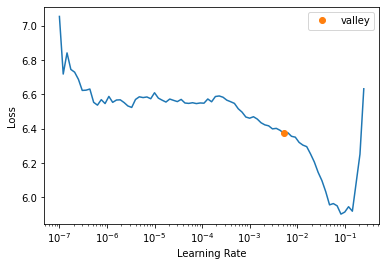

In [39]:
learn.lr_find()

In [40]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,2.624734,2.547091,00:01
1,2.401672,2.413832,00:01
2,2.355546,2.349405,00:01
3,2.319987,2.350806,00:01
4,2.269614,2.374900,00:01


In [41]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3154,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,15,6,227,False,False,False,False,False,False,1.628986e+09


In [42]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [43]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [44]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(4.3789) tensor(4.3789)
tensor(5.3554) tensor(5.3554)


In [45]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [46]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [47]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [48]:
prob_lo, prob_hi

(tensor(0.6162), tensor(0.3838))

## Negative Binomial

In [18]:
y_block = RegressionBlock(n_out=5)

In [19]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [20]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC
0,D1,Mainz,Stuttgart,5,0.8,12.800000,4.0,6.4,2.4,16.600000,7.6,5.2,1.2,12.6,4.8,5.2,3.0,16.0,7.2,7.6,1.2,15.8,5.2,7.6,1.8,9.2,3.6,3.2,2020.0,9.0,39.000000,26.0,269.999998,3.0,9.0
1,E1,QPR,Birmingham,5,1.6,16.200001,5.2,6.6,2.0,10.000000,3.4,3.8,0.8,13.4,4.0,4.2,1.6,11.4,3.4,4.0,1.8,13.0,4.2,6.2,1.8,12.2,5.2,6.4,2019.0,2.0,6.000000,9.0,40.000001,6.0,3.0
2,SP2,Sabadell,Albacete,4,0.8,9.400000,2.8,4.8,1.2,7.800000,2.4,4.0,0.8,8.6,3.2,6.6,0.8,8.6,2.6,4.6,0.8,9.8,4.0,4.2,1.2,11.0,3.8,5.2,2021.0,2.0,7.999999,26.0,56.999999,6.0,2.0
3,F2,Metz,Nancy,1,1.4,14.200000,4.0,5.0,1.2,9.400000,4.2,2.8,1.2,12.0,3.8,5.4,1.0,8.8,3.4,3.2,0.4,7.2,2.0,3.0,1.2,12.0,5.4,3.2,2019.0,1.0,5.000000,29.0,29.000006,11.0,2.0
4,I1,Inter,Milan,6,1.4,14.400000,7.2,9.2,1.8,9.800000,6.8,6.4,1.4,13.4,6.2,9.2,2.2,13.2,8.6,7.8,0.6,8.2,5.0,4.2,1.2,7.2,3.6,5.0,2018.0,10.0,42.000000,21.0,294.000001,9.0,4.0
5,I2,Crotone,Spezia,6,2.2,19.000000,6.4,7.8,0.8,10.400000,3.2,3.4,2.0,14.6,5.4,5.0,1.0,9.4,3.2,2.0,1.0,10.4,4.0,4.6,0.4,12.2,4.4,4.0,2020.0,1.0,4.000001,26.0,26.000004,6.0,8.0
6,D1,Dortmund,Bayern Munich,5,2.0,12.800000,5.4,4.0,2.4,13.400000,6.4,6.4,2.0,17.0,7.2,7.8,3.2,15.8,7.2,6.4,0.4,5.6,2.2,2.2,1.8,11.0,4.4,3.4,2020.0,11.0,45.000000,7.0,311.999995,4.0,3.0
7,I2,Ascoli,Frosinone,1,1.2,12.000000,3.8,3.6,0.6,11.000000,2.4,3.0,1.2,12.6,4.4,4.8,0.6,13.6,3.0,4.4,0.8,11.4,4.0,5.8,1.2,11.4,4.2,4.6,2021.0,2.0,6.000000,9.0,40.000001,4.0,5.0
8,E1,Leeds,Birmingham,5,0.8,15.600000,5.0,7.8,0.6,10.600000,2.8,5.2,1.0,15.4,5.2,7.6,1.0,14.6,4.4,7.4,0.8,9.2,4.2,4.4,1.2,8.0,3.2,2.8,2019.0,10.0,42.000000,19.0,292.000003,9.0,2.0
9,E2,Burton,Sunderland,5,1.2,10.800000,2.6,6.2,1.4,15.399999,5.6,5.0,1.0,9.4,2.2,4.4,2.0,15.2,6.6,5.2,1.2,10.4,3.6,4.0,1.4,13.8,5.0,3.6,2021.0,2.0,7.000000,20.0,50.999996,7.0,5.0


In [21]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [22]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [23]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.005495408549904823)

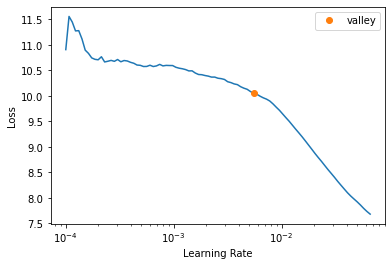

In [24]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=1e-01)

In [25]:
learn_bnb.fit_one_cycle(4, 2e-2)

epoch,train_loss,valid_loss,time
0,5.030169,4.725767,00:01
1,4.712561,4.663130,00:01
2,4.645205,4.694812,00:01
3,4.577554,4.714162,00:01


In [26]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
3154,E0,Tottenham,Man City,1.0,0.0,13.0,18.0,3.0,4.0,3.0,...,15,6,227,False,False,False,False,False,False,1.628986e+09


In [27]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [28]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [29]:
params

tensor([-2.5541, -2.5118,  4.2150,  5.4424, -0.3566])

In [32]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = torch.tanh(params[4]) * 0.0

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.0749, 0.0780]) tensor([4.2297, 5.4467]) tensor(-0.)


In [33]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [34]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([4.2297, 5.4467]) tensor([5.5694, 7.7607])


In [35]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([4.2297, 5.4467]) tensor([5.5694, 7.7607])


In [36]:
d = 1.-math.exp(-1)
corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
corr 

tensor(-0.)

In [37]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

In [38]:
corner = bnb_corner.log_prob(value).exp()

In [39]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [40]:
prob_lo, prob_hi

(tensor(0.6187), tensor(0.3813))

In [41]:
1/prob_lo, 1/prob_hi

(tensor(1.6164), tensor(2.6224))

### Train full model

In [58]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [59]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,Dayofweek,FTHGLast5Avg,HSLast5Avg,HSTLast5Avg,HCLast5Avg,FTAGLast5Avg,ASLast5Avg,ASTLast5Avg,ACLast5Avg,HomeFTGForLast5Avg,HomeSForLast5Avg,HomeSTForLast5Avg,HomeCForLast5Avg,AwayFTGForLast5Avg,AwaySForLast5Avg,AwaySTForLast5Avg,AwayCForLast5Avg,HomeFTGAgainstLast5Avg,HomeSAgainstLast5Avg,HomeSTAgainstLast5Avg,HomeCAgainstLast5Avg,AwayFTGAgainstLast5Avg,AwaySAgainstLast5Avg,AwaySTAgainstLast5Avg,AwayCAgainstLast5Avg,Year,Month,Week,Day,Dayofyear,HC,AC
0,E2,Walsall,Fleetwood Town,5,1.4,9.2,3.2,4.4,1.2,7.6,3.6,3.6,0.6,7.000000,2.8,3.4,1.0,9.200000,2.8,4.8,1.6,13.000000,5.6,4.6,0.6,9.0,1.8,6.8,2019.0,3.0,10.000001,9.0,67.999999,7.0,2.0
1,E2,Charlton,Accrington,1,1.2,12.6,3.6,5.6,1.0,16.6,4.2,5.6,1.4,11.400000,4.4,5.4,1.4,14.400000,4.6,4.6,2.0,12.400000,4.4,4.2,2.8,11.6,5.2,6.0,2021.0,10.0,42.000000,19.0,292.000002,8.0,5.0
2,I1,Atalanta,Napoli,0,1.4,14.2,7.8,8.0,1.8,11.2,6.2,5.4,3.2,14.399999,8.6,4.8,2.2,15.200000,8.0,9.8,1.2,7.800000,4.4,4.2,0.6,7.4,3.8,3.4,2018.0,12.0,48.999999,3.0,336.999999,12.0,6.0
3,D2,Erzgebirge Aue,Stuttgart,4,1.6,12.4,3.2,2.8,0.6,15.4,5.2,5.8,1.4,11.600000,6.0,1.2,1.8,16.200001,6.8,5.4,1.4,16.200001,5.2,6.6,0.8,11.4,2.8,5.0,2019.0,8.0,34.000000,23.0,235.000001,2.0,7.0
4,D2,Nurnberg,Bielefeld,6,1.2,18.6,6.0,7.6,2.4,11.8,5.4,5.4,2.0,14.200000,4.6,5.6,1.0,12.400000,4.8,5.8,1.8,10.800000,3.2,3.2,0.6,10.6,2.8,3.4,2019.0,11.0,44.999999,10.0,313.999995,8.0,1.0
5,F2,Grenoble,Lorient,4,0.8,12.2,4.8,4.0,0.6,10.4,2.6,4.6,0.8,11.800000,4.2,5.6,1.0,11.000000,2.8,5.2,1.6,13.000000,4.6,3.4,0.8,7.6,2.4,3.4,2019.0,2.0,6.000000,8.0,39.000002,8.0,2.0
6,SP1,Barcelona,Huesca,0,2.4,14.8,5.8,6.2,1.0,11.2,4.0,5.6,2.6,13.600000,5.8,5.2,1.6,12.000000,4.2,4.4,0.4,5.800000,1.8,2.6,2.0,13.4,5.2,5.4,2021.0,3.0,11.000000,15.0,74.000006,7.0,3.0
7,E0,West Ham,Newcastle,5,1.2,10.4,5.0,4.8,0.6,6.8,1.4,2.4,1.2,10.800000,4.8,4.6,0.4,8.800000,1.6,2.4,1.4,11.600000,5.2,6.0,1.4,14.0,4.8,7.0,2019.0,11.0,44.000000,2.0,306.000002,7.0,3.0
8,F2,Chambly,Sochaux,4,1.8,11.6,3.4,4.2,1.2,11.2,3.8,3.4,1.6,10.200000,3.2,3.0,0.4,11.000000,4.6,3.6,2.0,12.800000,5.0,6.4,1.2,13.4,5.4,3.2,2021.0,2.0,4.999999,5.0,35.999999,6.0,3.0
9,E0,Man United,Arsenal,6,1.0,10.2,3.6,5.2,1.0,9.6,3.2,5.2,1.8,13.400000,5.4,5.6,1.0,8.000000,3.6,5.4,2.4,13.400000,4.6,4.0,1.4,12.0,4.0,5.0,2020.0,11.0,44.000000,1.0,306.000002,6.0,3.0


In [60]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [61]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(268, 37)
    (2): Embedding(268, 37)
    (3): Embedding(8, 5)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(29, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=114, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [62]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.019054606556892395)

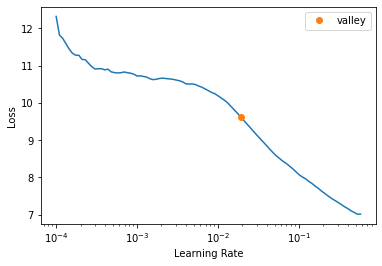

In [63]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=1e-00)

In [64]:
learn_bnb.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,time
0,5.128230,None,00:01
1,4.691135,None,00:01
2,4.645761,None,00:01
3,4.570922,None,00:01


/home/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [65]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [66]:
to.export('models/to.pkl')

### t-SNE

In [67]:
df['HomeTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [68]:
df['AwayTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves',
       'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens',
       'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento',
       'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia',
       'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos',
       'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge',
       'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'D

In [69]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 267
['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Ajaccio GFCO', 'Alaves', 'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta', 'Angers', 'Arsenal', 'Ascoli', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Beziers', 'Bielefeld', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Bournemouth', 'Bradford', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff', 'Cartagena', 'Castellon', 'Celta', 'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo', 'Cittadella', 'Clermont', 'Como', 'Cordoba', 'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby', 'Dijon', 'Doncaster', 'Dortmund', 'Dresden', 'Duisburg', 'Dunkerque', 'Eibar', 'Ein Frankfurt

In [70]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

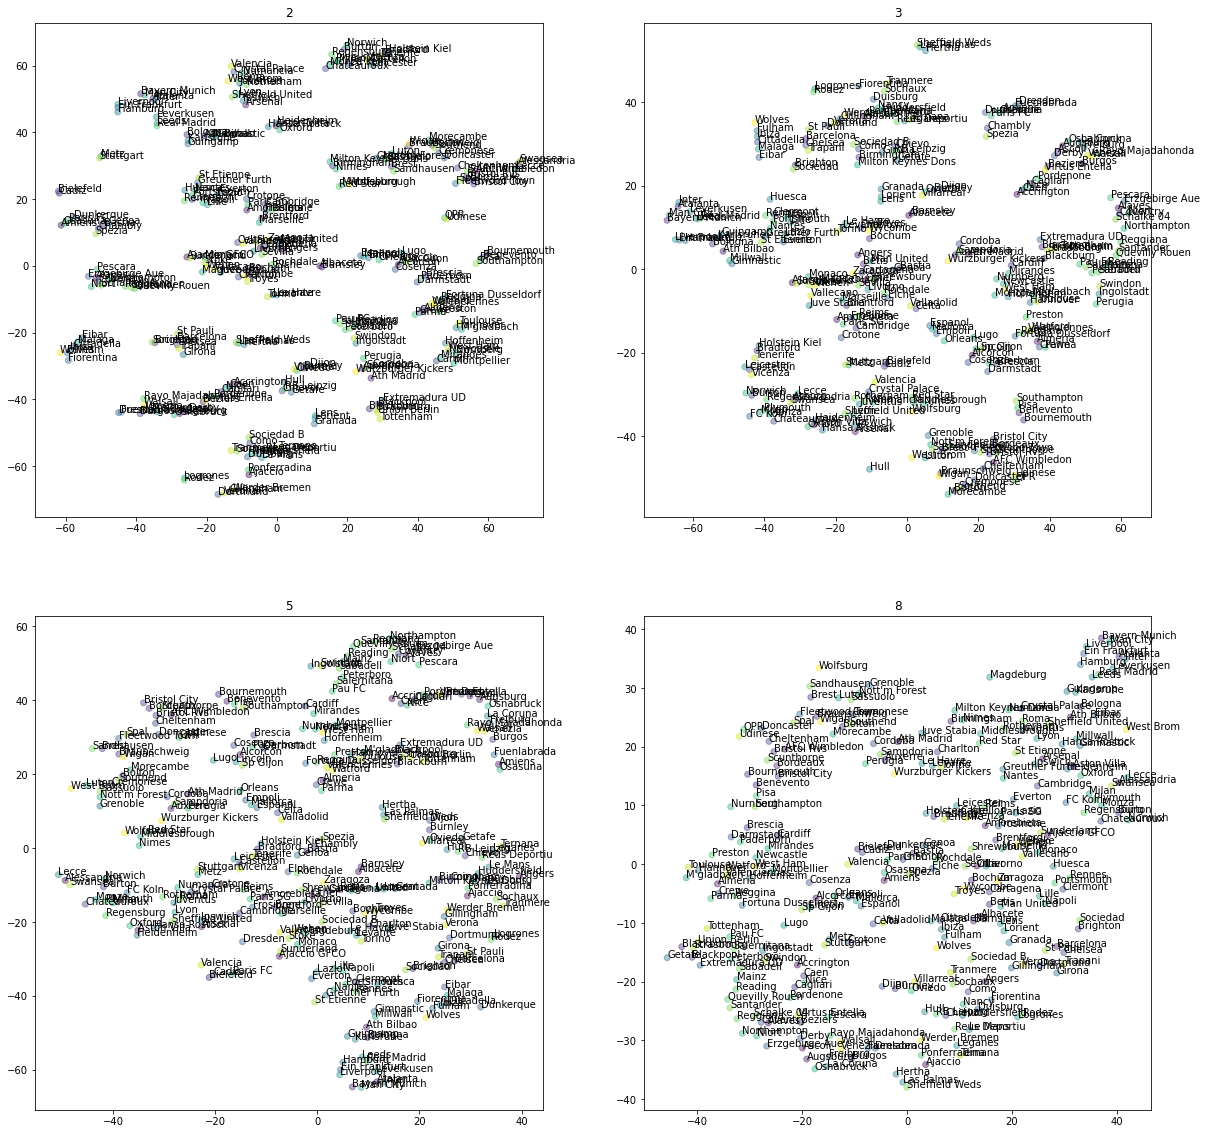

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END